In [1]:
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from qutip import bloch_redfield_tensor, QobjEvo, basis

from plotstyle import init_style, COLORS
init_style()

from qspectro2d.config import SCRIPTS_DIR

from qspectro2d.spectroscopy import compute_2d_fft_wavenumber

# Visualization (updated centralized helpers)
from qspectro2d.visualization import (
    plot_example_evo,
    plot_example_polarization,
    plot_2d_el_field,
)

from qspectro2d.spectroscopy.one_d_field import compute_evolution

# Utilities (updated path after refactor)
from qspectro2d.utils import (
    save_data_file,
    save_info_file,
    generate_unique_data_filename,
)
from qspectro2d.config import create_base_sim_oqs

# Core simulation + system components (new module locations)
from qspectro2d.core.simulation import SimulationConfig, SimulationModuleOQS
from qspectro2d.core.atomic_system.system_class import AtomicSystem
from qspectro2d.core.laser_system.laser_class import LaserPulseSequence
from qspectro2d.core.bath_system import extract_bath_parameters

In [2]:
config_path = SCRIPTS_DIR / "config.yaml"
# Build base simulation (applies CLI overrides inside)
sim_oqs, time_cut = create_base_sim_oqs(config_path=str(config_path) if config_path else None)

🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
H at t=0: 3.014178508727111
H at t=0: 3.014178508727111
H at t=0: 3.014178508727111
H at t=0: 3.014178508727111
H at t=-12.0: 3.0139183281479043
H at t=-11.999999836370717: 3.0139183281479043
H at t=-11.999871772609453: 3.0139183281479043
H at t=-11.999935886304726: 3.0139183281479043
H at t=-11.358798933566193: 3.0139183281479043
H at t=-4.947429406180865: 3.0139200610762646
H at t=-9.755956551719862: 3.0139183281479043
H at t=-8.153114169873529: 3.0139183281479043
H at t=7.875309648589795: 3.013922507982536
H at t=-4.146008215257698: 3.0139322865742266
H at t=-7.151337681219571: 3.0139183281479043
H at t=-6.1495611925656135: 3.0139184069603084
H at t=-6.900893559056081: 3.0139183281479043
H at t=-6.6504494368925915: 3.0139183281479043
H at t=-4.146008215257697: 3.0139322865742266
H at t=-6.024339131483868: 3.013918425556449
H at t=-6.493921860540411: 3.0139183291921094
H at t=-6.611317542804546: 3

In [3]:
from curses import meta
from qspectro2d.utils.data_io import save_simulation_data
avg_E_sigs = [np.zeros((len(sim_oqs.t_det), ), dtype=complex)]
metadata = {
    "n_batches": 1,
    "signal_types": sim_oqs.simulation_config.signal_types,
}
abs_data_path = save_simulation_data(
    sim_oqs, metadata, avg_E_sigs, t_det=sim_oqs.t_det
)
abs_data_path
str(abs_data_path)

2025-09-18 16:38:55 | INFO | qspectro2d.utils.data_io:129 | Info saved: /home/leopold/Projects/Master_thesis/data/1d_spectroscopy/N1/f16000cm_mu1.0/ME/noRWA/t_dm60.0_t_wait_10.0_dt_0.1/t_coh_6.0_info.pkl


'/home/leopold/Projects/Master_thesis/data/1d_spectroscopy/N1/f16000cm_mu1.0/ME/noRWA/t_dm60.0_t_wait_10.0_dt_0.1/t_coh_6.0_data.npz'

LaserPulseSequence Summary
--------------------------------------------------------------------------------
Pulse  0: t =   0.00 fs | E₀ = 1.000e-02 | FWHM =  6.0 fs | ω = 16000.00 cm^-1 | ϕ =  0.000 rad | type = gaussian
H at t=0: 3.014164876878571
H at t=-12.0: 3.0139183281479043
H at t=-11.999999948380863: 3.0139183281479043
H at t=-11.999977280154807: 3.0139183281479043
H at t=-11.999988640077403: 3.0139183281479043
H at t=-11.886389414112791: 3.0139183281479043
H at t=-10.750397154466677: 3.0139183281479043
H at t=0.6095254419944673: 3.0139344143783178
H at t=-7.910416505351391: 3.0139183281479043
H at t=-5.070435856236104: 3.0139206113002084
H at t=-7.200421343072569: 3.0139183281479043
H at t=-6.490426180793747: 3.0139183293237615
H at t=-7.022922552502863: 3.0139183281479043
H at t=-6.845423761933158: 3.0139183281479043
H at t=-5.070435856236104: 3.0139206113002084
H at t=-6.4016767855088945: 3.013918336932676
H at t=-6.7344870178270915: 3.0139183281479043
H at t=-6.62355027372

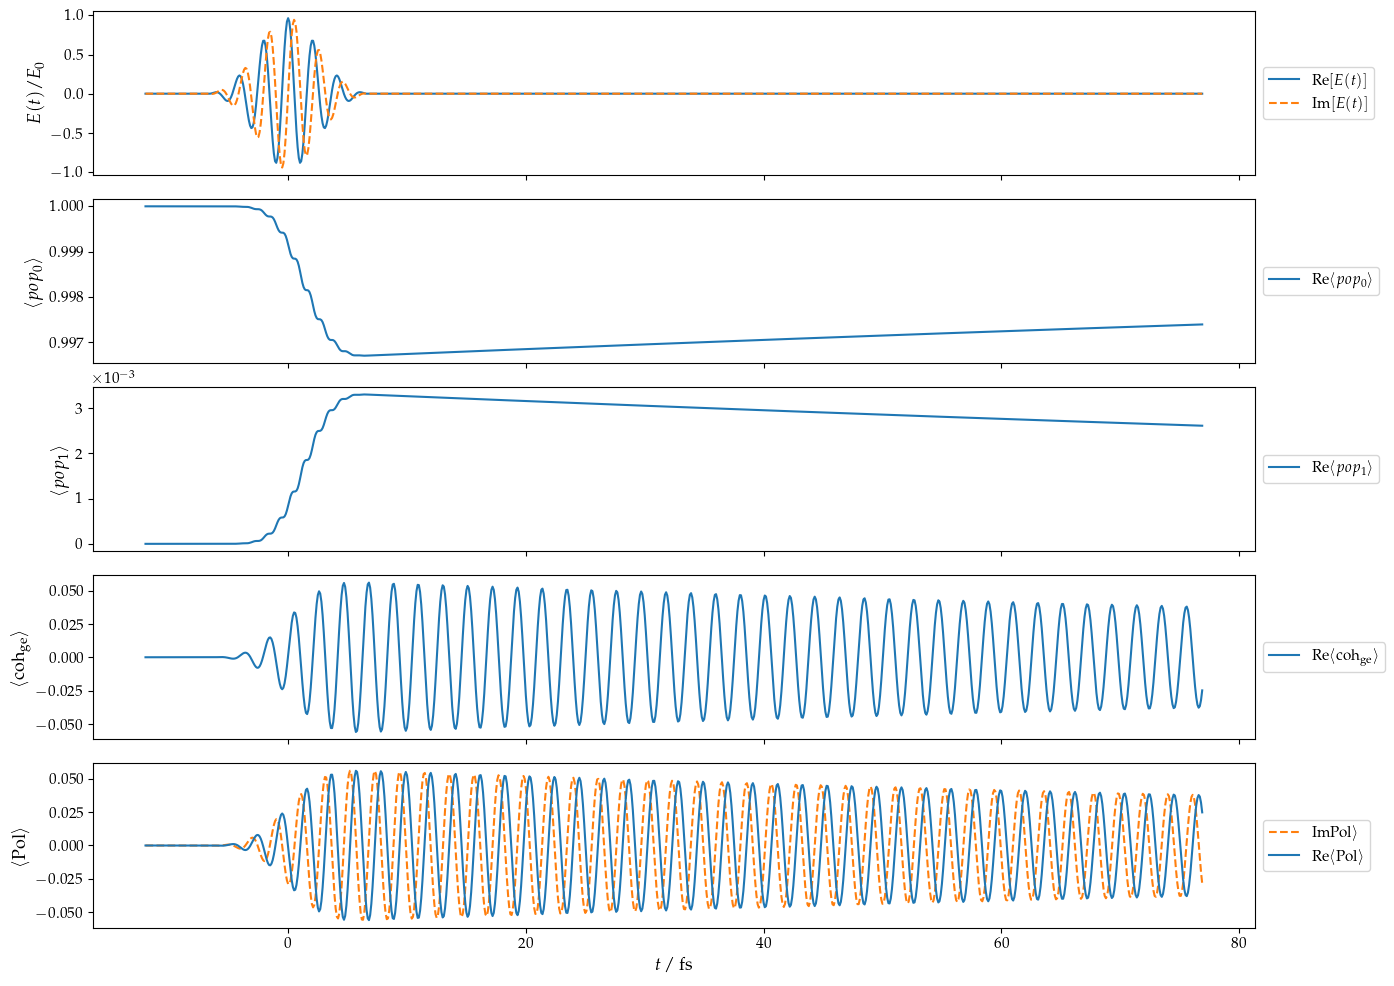

In [4]:
from qspectro2d.spectroscopy.one_d_field import _with_only_pulse_i_active
from qspectro2d.utils.units_and_rwa import from_rotating_frame_list, get_expect_vals_with_RWA

sim_oqs = _with_only_pulse_i_active(sim_oqs, 0)
print(sim_oqs.laser)
res = compute_evolution(sim_oqs)
det_states = res.states


times = res.times
rwa_sl = sim_oqs.simulation_config.rwa_sl
if rwa_sl:
    # States are stored in the rotating frame; convert back to lab for polarization
    det_states = from_rotating_frame_list(
        det_states, times, sim_oqs.system.n_atoms, sim_oqs.laser._carrier_freq_fs
    )
expectation_values = get_expect_vals_with_RWA(det_states, 
                                              times, 
                                              sim_oqs.system.n_atoms,
                                              sim_oqs.observable_ops, 
                                              sim_oqs.laser._carrier_freq_fs,
                                              rwa_sl=rwa_sl,
                                              dipole_op=sim_oqs.system.dipole_op)

fig_evo = plot_example_evo(times, expectation_values, sim_oqs.laser, rwa_sl=rwa_sl, observable_strs=sim_oqs.observable_strs)
display(fig_evo)

In [5]:
times, datas, sim_oqs = compute_1d_polarization(sim_oqs=sim_oqs, plot_example_evo=True, dipole_op = True)
rwa_sl = sim_oqs.simulation_config.rwa_sl
print(f"RWA (rwa_sl)", rwa_sl)


NameError: name 'compute_1d_polarization' is not defined

In [ ]:
t_coh_range = sim_oqs.t_det
rwa_sl = sim_oqs.simulation_config.rwa_sl

# Store results for each t_coh
results_matrices_2d = {}
signal_components_2d = {}

start_time_2d = time.time()

for i, t_coh in enumerate(t_coh_range[::10]):
    print(f"\n--- Processing t_coh = {t_coh:.1f} fs ({i+1}/{len(t_coh_range[::10])}) ---")
    
    # Update t_coh in the simulation config
    sim_config_obj = sim_oqs.simulation_config
    original_t_coh = sim_config_obj.t_coh
    sim_config_obj.t_coh = t_coh
    t_wait = sim_config_obj.t_wait
    t_det_max = sim_config_obj.t_det_max
    sim_config_obj.t_max = t_wait + 2 * t_det_max

    # Clear cached global / local time arrays so they rebuild with new t_max
    if hasattr(sim_oqs, "_times_global"):
        delattr(sim_oqs, "_times_global")
    sim_oqs.reset_times_local()
    
    sim_oqs.laser.update_delays([t_coh, t_wait])  # Note hard to extend to n pulses

    times, datas, sim_oqs = compute_1d_polarization(sim_oqs=sim_oqs, plot_example_evo=True, dipole_op=True)
    print(f"RWA (rwa_sl)", rwa_sl)
    fig_evo = plot_example_evo(times, datas, sim_oqs.laser, rwa_sl=rwa_sl, observable_strs=sim_oqs.observable_strs, **dict_combined)
    display(fig_evo)



In [ ]:
plot_data = compute_1d_polarization(sim_oqs, time_cut=time_cut, plot_example_polarization = True)
P_full, P_only0, P_only1, P_only2 = plot_data
times = sim_oqs.t_det

pulse_seq = sim_oqs.laser
rwa_sl = sim_oqs.simulation_config.rwa_sl
observable_strs = sim_oqs.observable_strs

plot_example_polarization(times, P_full, P_only0, P_only1, P_only2)

## Step-by-step spectroscopy workflow

This section recreates the logic of `calc_datas.py` but broken into small, testable steps so you can visually validate physics after each stage:

1. Inspect / visualize pulse sequence (envelope, RWA field, full field).
2. Validate solver stability (extended evolution) and obtain `time_cut`.
3. **STEP 3a**: Compute raw results matrix (phase-resolved polarization matrix) for single t_coh.
4. **STEP 3b**: Extract IFT signal components from the results matrix for single t_coh.
5. **STEP 3a-2D**: Compute raw results matrix for multiple coherence times (2D simulation).
6. **STEP 3b-2D**: Extract IFT signal components for multiple coherence times.
7. Transform and inspect frequency-domain representation (1D and 2D).
8. (Optional) Scan multiple coherence times to progressively assemble a 2D data set with live partial visualization.
9. Save intermediate / final results (NPZ + info) using the usual I/O helpers.

Adjust parameters at the top of each code cell to iterate quickly. Each code cell is independent where possible to encourage experimentation.

In [ ]:
# STEP 1: Inspect and visualize pulse sequence
# You can re-run this after changing the config or modifying delays.
from qspectro2d.visualization.plotting import plot_all_pulse_components

_times_pulse = np.linspace(
    -4 * sim_oqs.laser.pulse_fwhms[0],
    sim_oqs.simulation_config.t_coh + sim_oqs.simulation_config.t_wait + 4 * sim_oqs.laser.pulse_fwhms[0],
    1200,
)

fig_pulses = plot_all_pulse_components(_times_pulse, sim_oqs.laser)
display(fig_pulses)
print("det_times", sim_oqs.t_det)

In [ ]:
# STEP 2: Solver validation (extended evolution)
# Re-runs validation to get (possibly) updated time_cut threshold for instability.
from qspectro2d.spectroscopy.solver_check import check_the_solver

res_val, time_cut_new = check_the_solver(sim_oqs)
print(f"time_cut (old) = {time_cut:.3f} fs, time_cut (new) = {time_cut_new:.3f} fs")
# Keep the stricter (earlier) cutoff for safety
time_cut = min(time_cut, time_cut_new) if time_cut != -np.inf else time_cut_new
print(f"Using time_cut = {time_cut:.3f} fs for subsequent truncations (if finite).")

In [ ]:
# STEP 3a: Compute raw results matrix (phase-resolved polarization)
# This performs all expensive solver calls and returns the averaged nonlinear polarization matrix
from qspectro2d.spectroscopy.calculations import compute_1d_pol_matrix_phases

print(f"Running 1D simulation at t_coh = {sim_oqs.simulation_config.t_coh:.2f} fs")
print("Computing phase-resolved polarization matrix...")

# Compute the raw results matrix (this is the expensive part)
Pol_matrix_phases = compute_1d_pol_matrix_phases(sim_oqs=sim_oqs, time_cut=time_cut)

print(f"Results matrix shape: {Pol_matrix_phases.shape}")
print(f"Matrix contains {np.isnan(Pol_matrix_phases).sum()} NaN values")

# Plot a slice of the raw results matrix (e.g., phi1=0, all phi2)
_t_det = sim_oqs.t_det
n_phases = sim_oqs.simulation_config.n_phases

fig_matrix = plt.figure(figsize=(12, 8))
for phi1_idx in range(min(4, n_phases)):  # Show first 4 phi1 values
    plt.subplot(2, 2, phi1_idx + 1)
    for phi2_idx in range(n_phases):
        plt.plot(_t_det, np.real(Pol_matrix_phases[phi1_idx, phi2_idx, :]),
                label=f'$\phi_2$={phi2_idx}', c=COLORS[phi2_idx], alpha=0.7)
    plt.xlabel('Detection Time (fs)')
    plt.ylabel('Re[Polarization]')
    plt.title(f'Raw Matrix: $\phi_1$={phi1_idx}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
display(fig_matrix)

print("Raw results matrix computed and visualized.")

In [ ]:
# STEP 3b: Extract IFT signal components from the results matrix
from qspectro2d.spectroscopy.calculations import extract_P_lmn_1d
from qspectro2d.visualization.plotting import plot_1d_el_field

print("Extracting IFT signal components...")

# Extract the signal components using inverse Fourier transform
signal_components = extract_P_lmn_1d(Pol_matrix_phases, sim_oqs)

print(f"Extracted signal components: {list(signal_components.keys())}")

# Now create the final _datas list (same format as original function)
_datas = [signal_components[sig] for sig in sim_oqs.simulation_config.signal_types if sig in signal_components]

print(f"Final _datas list contains {len(_datas)} components")

# Visualize the extracted signal components
_t_det = sim_oqs.t_det

fig_components = plt.figure(figsize=(15, 10))
n_components = len(_datas)

for i, (sig_type, component_data) in enumerate(zip(sim_oqs.simulation_config.signal_types, _datas)):
    plt.subplot(2, (n_components + 1) // 2, i + 1)
    
    # Plot real and imaginary parts
    plt.plot(_t_det, np.real(component_data), 'b-', label='Real', alpha=0.8)
    plt.plot(_t_det, np.imag(component_data), 'r--', label='Imag', alpha=0.8)
    
    plt.xlabel('Detection Time (fs)')
    plt.ylabel('Polarization')
    plt.title(f'{sig_type.capitalize()} Signal')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
display(fig_components)

if _datas:
    _pol = _datas[0]  # First component (usually rephasing)
    fig_1d_real = plot_1d_el_field(_t_det, _pol, domain='time', component='real', function_symbol='P')
    fig_1d_abs = plot_1d_el_field(_t_det, _pol, domain='time', component='abs', function_symbol='P')
    
    display(fig_1d_real)
    display(fig_1d_abs)

print("IFT signal components extracted and visualized.")

In [ ]:
# STEP 4: Frequency-domain view of the single 1D signal
# Apply FFT with simple zero-padding (optional) for better interpolation.
_pad_factor = 2
N = len(_pol)
N_pad = int(2 ** np.ceil(np.log2(N * _pad_factor)))
_pol_padded = np.zeros(N_pad, dtype=complex)
_pol_padded[:N] = _pol
# Frequency axis (cycles / fs)
_dt = np.diff(_t_det).mean()
_freq = np.fft.fftfreq(N_pad, d=_dt)
FFT = np.fft.fft(_pol_padded)
# Keep only positive branch for plotting
pos_mask = _freq >= 0
_freq_pos = _freq[pos_mask]
FFT_pos = FFT[pos_mask]
# STEP 4: Frequency-domain view of the single 1D signal
# Apply FFT with simple zero-padding (optional) for better interpolation.
_pad_factor = 2
N = len(_pol)
N_pad = int(2 ** np.ceil(np.log2(N * _pad_factor)))
_pol_padded = np.zeros(N_pad, dtype=complex)
_pol_padded[:N] = _pol
# Frequency axis (cycles / fs)
_dt = np.diff(_t_det).mean()
_freq = np.fft.fftfreq(N_pad, d=_dt)
FFT = np.fft.fft(_pol_padded)
# Keep only positive branch for plotting
pos_mask = _freq >= 0
_freq_pos = _freq[pos_mask]
FFT_pos = FFT[pos_mask]

fig_fft_abs = plot_1d_el_field(_freq_pos, FFT_pos, domain='freq', component='abs', function_symbol=r'\tilde{P}', title=r'$|\mathrm{FFT}[P(t)]|$')
fig_fft_real = plot_1d_el_field(_freq_pos, FFT_pos, domain='freq', component='real', function_symbol=r'\tilde{P}', title=r'$\mathrm{Re}\ \mathrm{FFT}[P(t)]$')

# Display the figures
display(fig_fft_abs)
display(fig_fft_real)

In [ ]:
# STEP 3a-2D: Compute raw results matrix for multiple coherence times (2D simulation)
# This performs the expensive solver calls for multiple t_coh values to build the 2D dataset
from qspectro2d.spectroscopy.calculations import compute_1d_pol_matrix_phases

# Define range of coherence times for 2D simulation
t_coh_range = sim_oqs.t_det
print(f"Running 2D simulation with {len(t_coh_range)} coherence times: [{t_coh_range[0]:.1f}, {t_coh_range[-1]:.1f}] fs")

# Store results for each t_coh
results_matrices_2d = {}
signal_components_2d = {}

start_time_2d = time.time()

for i, t_coh in enumerate(t_coh_range):
    print(f"\n--- Processing t_coh = {t_coh:.1f} fs ({i+1}/{len(t_coh_range)}) ---")
    
    # Update t_coh in the simulation config
    sim_config_obj = sim_oqs.simulation_config
    original_t_coh = sim_config_obj.t_coh
    sim_config_obj.t_coh = t_coh
    t_wait = sim_config_obj.t_wait
    t_det_max = sim_config_obj.t_det_max
    sim_config_obj.t_max = t_wait + 2 * t_det_max

    # Clear cached global / local time arrays so they rebuild with new t_max
    if hasattr(sim_oqs, "_times_global"):
        delattr(sim_oqs, "_times_global")
    sim_oqs.reset_times_local()
    
    sim_oqs.laser.update_delays([t_coh, t_wait])  # Note hard to extend to n pulses

    # Compute the raw results matrix for this t_coh
    Pol_matrix_phases = compute_1d_pol_matrix_phases(sim_oqs=sim_oqs, time_cut=time_cut)
    results_matrices_2d[t_coh] = Pol_matrix_phases
    
    print(f"Results matrix shape: {Pol_matrix_phases.shape}")

# Restore original t_coh
sim_config_obj.t_coh = original_t_coh
sim_oqs.laser.update_delays([original_t_coh, sim_config_obj.t_wait])

elapsed_time_2d = time.time() - start_time_2d
print(f"\n✅ 2D raw results matrices computed in {elapsed_time_2d:.2f} seconds")
print(f"Total matrices stored: {len(results_matrices_2d)}")

In [ ]:
dummy_phi1_idx = 3
dummy_phi2_idx = 1
data_2d_raw = np.array([results_matrices_2d[t_coh][dummy_phi1_idx, dummy_phi2_idx, :] for t_coh in t_coh_range])
# Plot real part
fig_2d_real = plot_2d_el_field(
    t_coh_range, 
    t_coh_range, 
    data_2d_raw,  # Example: phi1=0, phi2=0 slice
    domain='time', 
    component='real',
)
display(fig_2d_real)

In [ ]:
# Quick visualization of 3 slices at the start, middle, and end of t_coh_range
# Select three representative coherence times
t_coh_indices = [0, len(t_coh_range)//2, -1]  # start, middle, end
t_coh_samples = [t_coh_range[i] for i in t_coh_indices]
sample_matrices = [results_matrices_2d[t_coh] for t_coh in t_coh_samples]

fig_matrix_2d = plt.figure(figsize=(18, 12))
plot_idx = 1

for slice_idx, (t_coh, matrix) in enumerate(zip(t_coh_samples, sample_matrices)):
    for phi1_idx in range(min(4, sim_oqs.simulation_config.n_phases)):
        plt.subplot(3, 4, plot_idx)  # 3 rows (t_coh slices) x 4 columns (phi1 values)
        
        for phi2_idx in range(sim_oqs.simulation_config.n_phases):
            plt.plot(_t_det, np.real(matrix[phi1_idx, phi2_idx, :]),
                    label=f'$\phi_2$={phi2_idx}', c=COLORS[phi2_idx], alpha=0.7)
        
        plt.xlabel('Detection Time (fs)')
        plt.ylabel('Re[Polarization]')
        plt.title(f't_coh={t_coh:.1f} fs, $\phi_1$={phi1_idx}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plot_idx += 1

plt.tight_layout()

print("2D raw results matrices computed and visualized for start, middle, and end coherence times.")

In [ ]:
# here i just want the average plotted
# STEP 3b-2D: Extract IFT signal (BUT JUST average) components for multiple coherence times
for t_coh in t_coh_range:
    results_matrix = results_matrices_2d[t_coh]
    signal_components = extract_P_lmn_1d(results_matrix, sim_oqs)
    signal_components_2d[t_coh] = signal_components

print(f"Extracted signal components for {len(signal_components_2d)} coherence times")

# Organize data for 2D plotting
signal_types = sim_oqs.simulation_config.signal_types
n_t_coh = len(t_coh_range)
n_t_det = len(_t_det)

# Create 2D arrays: (t_coh, t_det) for each signal type
data_2d = {}
for sig_type in signal_types:
    data_2d[sig_type] = np.zeros((n_t_coh, n_t_det), dtype=complex)
    for i, t_coh in enumerate(t_coh_range):
        data_2d[sig_type][i, :] = signal_components_2d[t_coh][sig_type]

print(f"Created 2D data arrays with shape ({n_t_coh}, {n_t_det}) for signal types: {list(data_2d.keys())}")

# Visualize signal components at a few coherence times
fig_components_2d = plt.figure(figsize=(15, 12))
sample_indices = [0, len(t_coh_range)//4, len(t_coh_range)//2, 3*len(t_coh_range)//4, -1]

# Show 2D contour plot for one signal type using plot_2d_el_field
if signal_types:
    primary_sig = signal_types[0]
    
    # Plot real part
    fig_2d_real = plot_2d_el_field(
        _t_det, 
        t_coh_range, 
        data_2d[primary_sig], 
        domain='time', 
        component='real',
    )
    display(fig_2d_real)
    
    # Plot absolute value
    fig_2d_abs = plot_2d_el_field(
        _t_det, 
        t_coh_range, 
        data_2d[primary_sig], 
        domain='time', 
        component='abs',
    )
    display(fig_2d_abs)

# STEP 5: Transform to frequency domain using compute_2d_fft_wavenumber
from qspectro2d.spectroscopy.post_processing import compute_2d_fft_wavenumber

print("Transforming 2D time-domain data to frequency domain...")

# Prepare data for FFT - convert dictionary to list in correct order
data_list = [data_2d[sig] for sig in signal_types]

# Compute 2D FFT
nu_dets, nu_cohs, spectrum_2d = compute_2d_fft_wavenumber(
    t_dets=_t_det,
    t_cohs=t_coh_range,
    datas=data_list,
    signal_types=signal_types
)

print(f"Frequency domain spectrum shape: {spectrum_2d.shape}")
print(f"Detection wavenumber range: [{nu_dets.min():.1f}, {nu_dets.max():.1f}] × 10^4 cm⁻¹")
print(f"Coherence wavenumber range: [{nu_cohs.min():.1f}, {nu_cohs.max():.1f}] × 10^4 cm⁻¹")

# Plot the 2D frequency-domain spectrum
print("Plotting 2D frequency-domain spectrum...")
plot_config = {
    # "plot_time_domain": True,
    "extend_for": (1, 10),
    "spectral_components_to_plot": ["abs", "real", "img"],
    # "section": [(1, 3), (1, 3)],
    "section": [(1.4, 1.8), (1.4, 1.8)],
}

# Plot real part in frequency domain
fig_2d_freq_real = plot_2d_el_field(
    nu_dets, 
    nu_cohs, 
    spectrum_2d, 
    domain='freq', 
    component='real',
    **plot_config
)
display(fig_2d_freq_real)

# Plot absolute value in frequency domain
fig_2d_freq_abs = plot_2d_el_field(
    nu_dets, 
    nu_cohs, 
    spectrum_2d, 
    domain='freq', 
    component='abs',
    **plot_config

)
display(fig_2d_freq_abs)

print("2D frequency-domain spectrum computed and visualized.")

In [ ]:
# STEP 3b-2D: Extract IFT signal components for multiple coherence times
print("Extracting IFT signal components for 2D simulation...")

# Extract signal components for each t_coh
for t_coh in t_coh_range:
    results_matrix = results_matrices_2d[t_coh]
    signal_components = extract_P_lmn_1d(results_matrix, sim_oqs)
    signal_components_2d[t_coh] = signal_components

print(f"Extracted signal components for {len(signal_components_2d)} coherence times")

# Organize data for 2D plotting
signal_types = sim_oqs.simulation_config.signal_types
n_t_coh = len(t_coh_range)
n_t_det = len(_t_det)

# Create 2D arrays: (t_coh, t_det) for each signal type
data_2d = {}
for sig_type in signal_types:
    data_2d[sig_type] = np.zeros((n_t_coh, n_t_det), dtype=complex)
    for i, t_coh in enumerate(t_coh_range):
        data_2d[sig_type][i, :] = signal_components_2d[t_coh][sig_type]

print(f"Created 2D data arrays with shape ({n_t_coh}, {n_t_det}) for signal types: {list(data_2d.keys())}")

# Visualize signal components at a few coherence times
fig_components_2d = plt.figure(figsize=(15, 12))
sample_indices = [0, len(t_coh_range)//4, len(t_coh_range)//2, 3*len(t_coh_range)//4, -1]

for j, sig_type in enumerate(signal_types):
    for i, idx in enumerate(sample_indices):
        plt.subplot(len(signal_types), len(sample_indices), j*len(sample_indices) + i + 1)
        
        t_coh_sample = t_coh_range[idx]
        component_data = data_2d[sig_type][idx, :]
        
        plt.plot(_t_det, np.real(component_data), 'b-', label='Real', alpha=0.8)
        plt.plot(_t_det, np.imag(component_data), 'r--', label='Imag', alpha=0.8)
        plt.plot(_t_det, np.abs(component_data), 'g:', label='Abs', alpha=0.8)
        
        plt.xlabel('Detection Time (fs)')
        plt.ylabel('Polarization')
        plt.title(f'{sig_type.capitalize()}\nt_coh={t_coh_sample:.1f} fs')
        plt.legend()
        plt.grid(True, alpha=0.3)

plt.tight_layout()
display(fig_components_2d)

# Show 2D contour plot for one signal type using plot_2d_el_field
if signal_types:
    primary_sig = signal_types[0]
    
    # Plot real part
    fig_2d_real = plot_2d_el_field(
        _t_det, 
        t_coh_range, 
        data_2d[primary_sig], 
        domain='time', 
        component='real',
    )
    display(fig_2d_real)
    
    # Plot absolute value
    fig_2d_abs = plot_2d_el_field(
        _t_det, 
        t_coh_range, 
        data_2d[primary_sig], 
        domain='time', 
        component='abs',
    )
    display(fig_2d_abs)

# STEP 5: Transform to frequency domain using compute_2d_fft_wavenumber
from qspectro2d.spectroscopy.post_processing import compute_2d_fft_wavenumber

print("Transforming 2D time-domain data to frequency domain...")

# Prepare data for FFT - convert dictionary to list in correct order
data_list = [data_2d[sig] for sig in signal_types]

# Compute 2D FFT
nu_dets, nu_cohs, spectrum_2d = compute_2d_fft_wavenumber(
    t_dets=_t_det,
    t_cohs=t_coh_range,
    datas=data_list,
    signal_types=signal_types
)

print(f"Frequency domain spectrum shape: {spectrum_2d.shape}")
print(f"Detection wavenumber range: [{nu_dets.min():.1f}, {nu_dets.max():.1f}] × 10^4 cm⁻¹")
print(f"Coherence wavenumber range: [{nu_cohs.min():.1f}, {nu_cohs.max():.1f}] × 10^4 cm⁻¹")

# Plot the 2D frequency-domain spectrum
print("Plotting 2D frequency-domain spectrum...")
plot_config = {
    # "plot_time_domain": True,
    "extend_for": (1, 10),
    "spectral_components_to_plot": ["abs", "real", "img"],
    # "section": [(1, 3), (1, 3)],
    "section": [(1.4, 1.8), (1.4, 1.8)],
}

# Plot real part in frequency domain
fig_2d_freq_real = plot_2d_el_field(
    nu_dets, 
    nu_cohs, 
    spectrum_2d, 
    domain='freq', 
    component='real',
    **plot_config
)
display(fig_2d_freq_real)

# Plot absolute value in frequency domain
fig_2d_freq_abs = plot_2d_el_field(
    nu_dets, 
    nu_cohs, 
    spectrum_2d, 
    domain='freq', 
    component='abs',
    **plot_config

)
display(fig_2d_freq_abs)

print("2D frequency-domain spectrum computed and visualized.")

# Tests for `one_d_field.py` (phase cycling, inhomogeneity, and masking)

This section adds targeted tests to validate the phase-cycling math, inhomogeneous averaging strategy, and time-cut masking used by `parallel_compute_1d_e_comps` from `qspectro2d.spectroscopy.one_d_field`.

What we test:
- Phase-cycling extraction on synthetic data (`_phase_cycle_component`).
- Constant vs. phase-dependent grids to diagnose zero outputs.
- Component separation (rephasing vs. nonrephasing).
- Time-cut masking behavior (soft zeroing beyond cutoff).

In [ ]:
# Imports for tests
import numpy as np
from numpy.testing import assert_allclose, assert_array_equal
from qspectro2d.spectroscopy.one_d_field import _phase_cycle_component
from qspectro2d.config.default_simulation_params import COMPONENT_MAP, PHASE_CYCLING_PHASES, DETECTION_PHASE

def make_phase_set(n=4):
    phases = [float(x) for x in PHASE_CYCLING_PHASES[:n]]
    return phases

def lmn_for(sig: str):
    return COMPONENT_MAP[sig]

In [ ]:
# 1) Phase-cycling sanity checks with synthetic data
times = np.linspace(0.0, 10.0, 11)
n_t = len(times)
phases = make_phase_set(4)  # typical 4-phase scheme

# Build a synthetic P_grid that has explicit phase dependence:
# P_phi1,phi2(t) = A(t) * exp(+i*l0*phi1 + i*m0*phi2 + i*n0*phi_det)
A_t = 1.0 + 0.1*np.sin(0.3*times)
l0, m0, n0 = 1, -1, 1  # a specific component
phi_det = float(DETECTION_PHASE)
P_grid = np.zeros((len(phases), len(phases), n_t), dtype=np.complex128)
for i, phi1 in enumerate(phases):
    for j, phi2 in enumerate(phases):
        P_grid[i, j, :] = A_t * np.exp(1j*(l0*phi1 + m0*phi2 + n0*phi_det))

# Extract using our component extractor
P_extracted = _phase_cycle_component(phases, phases, P_grid, lmn=(l0, m0, n0), phi_det=phi_det, normalize=True)

# Expect to recover ~A_t (up to small numerical tolerance)
assert_allclose(P_extracted, A_t, rtol=1e-12, atol=1e-12)
print("[OK] Phase-cycling recovers designed component amplitude A(t).")

# Control: if we ask for the wrong (l,m,n), it should largely cancel
P_wrong = _phase_cycle_component(phases, phases, P_grid, lmn=(l0, m0+2, n0), phi_det=phi_det, normalize=True)
assert_allclose(np.max(np.abs(P_wrong)), 0.0, atol=1e-12)
print("[OK] Non-matching component cancels to ~0 as expected.")

In [ ]:
# 2) Diagnostic: why constant P_grid phase-cycles to zero
P_const = np.ones((len(phases), len(phases), n_t), dtype=np.complex128)
for sig in ["rephasing", "nonrephasing"]:
    lmn_sig = lmn_for(sig)
    P_comp = _phase_cycle_component(phases, phases, P_const, lmn=lmn_sig, phi_det=phi_det, normalize=True)
    print(sig, "max|P_comp|=", float(np.max(np.abs(P_comp))))
    assert_allclose(P_comp, 0.0, atol=1e-12)
print("[OK] Phase-cycling removes phase-independent contributions.")

In [ ]:
# 3) Component separation check: mix two components and extract each
A1 = 0.7 + 0.05*np.cos(0.4*times)
A2 = 1.3 + 0.08*np.sin(0.2*times)
lmns = [(1, -1, 1), (-1, 1, -1)]  # two components to mix
P_mix = np.zeros_like(P_grid)
for i, phi1 in enumerate(phases):
    for j, phi2 in enumerate(phases):
        P_mix[i, j, :] = (A1 * np.exp(1j*(lmns[0][0]*phi1 + lmns[0][1]*phi2 + lmns[0][2]*phi_det))
                          + A2 * np.exp(1j*(lmns[1][0]*phi1 + lmns[1][1]*phi2 + lmns[1][2]*phi_det)))

P1 = _phase_cycle_component(phases, phases, P_mix, lmn=lmns[0], phi_det=phi_det, normalize=True)
P2 = _phase_cycle_component(phases, phases, P_mix, lmn=lmns[1], phi_det=phi_det, normalize=True)
assert_allclose(P1, A1, rtol=1e-12, atol=1e-12)
assert_allclose(P2, A2, rtol=1e-12, atol=1e-12)
print("[OK] Mixed components are correctly separated by phase-cycling.")

In [ ]:
# 4) Time-cut masking behavior
def apply_mask(arr: np.ndarray, times: np.ndarray, cutoff: float) -> np.ndarray:
    mask = (times <= cutoff).astype(float)
    return arr * mask

cut = 5.0
arr = np.ones(n_t, dtype=np.complex128)
masked = apply_mask(arr, times, cut)
# Expect ones up to and including cutoff index, zeros after
assert_array_equal(masked.real, (times <= cut).astype(float))
print("[OK] Soft time-cut mask zeroes values beyond cutoff without changing length.")

In [ ]:
# 5) End-to-end smoke test stub for parallel_compute_1d_e_comps
from qspectro2d.spectroscopy.one_d_field import parallel_compute_1d_e_comps
from qspectro2d.core.simulation.simulation_class import SimulationModuleOQS
from qspectro2d.config import create_base_sim_oqs
from qspectro2d.config.default_simulation_params import *

try:
    sim, time_cut = create_base_sim_oqs()
    E_list = parallel_compute_1d_e_comps(sim, time_cut=10.0)
    assert isinstance(E_list, list)
    assert isinstance(E_list[0], np.ndarray)
    assert len(E_list) == len(sim.simulation_config.signal_types)
    for E in E_list:
        assert E.shape == (len(sim.t_det),)
        print(E)
    print("[OK] End-to-end smoke test for parallel_compute_1d_e_comps passed (shape + counts).")
except NotImplementedError as e:
    print("[SKIP] Provide a minimal SimulationModuleOQS to enable end-to-end smoke test:", e)